<a href="https://colab.research.google.com/github/mrmaggoo1/DesignOptimization2021Fall/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Solution trajectory:
[[1.         1.        ]
 [1.75       2.25      ]
 [0.93852422 1.54212187]
 [1.07054322 1.46526237]
 [1.06535854 1.46069188]
 [1.06020182 1.45616761]]


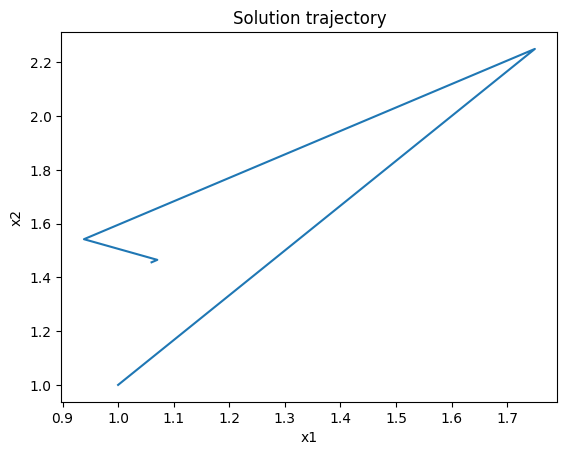

Text(0, 0.5, 'f(x)')

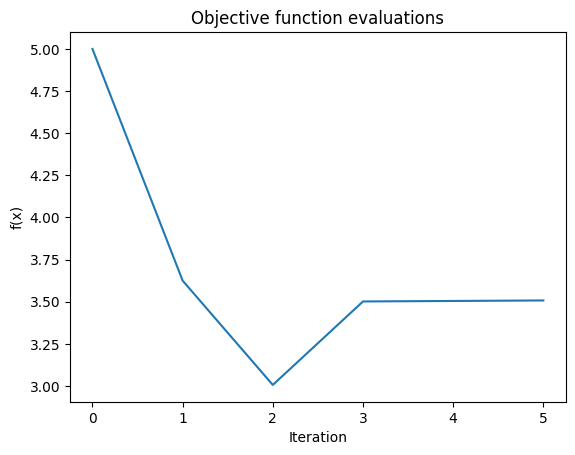

In [1]:
import numpy as np
import torch


# Helper functions
def split(array, slices):
    return np.array(np.array_split(array, slices)).squeeze()



# Problem formulation
def objective(x):
    return x[0]**2 + (x[1] - 3)**2

def df(x):
    return np.array([2*x[0], 2*(x[1]-3)])

def ineq_constraints(x):
    return np.array([x[1]**2 - 2*x[0], (x[1] - 1)**2 + 5*x[0] - 15])

def dg(x):
    return np.array([[-2, 2*x[1].item()],[5, 2*(x[1].item() - 1)]])

def lagrangian(x, mu):
    return objective(x) + np.dot(split(mu, 2),split(ineq_constraints(x), 2))

def dL(x, mu):
    return df(x) + np.dot(mu.transpose(), dg(x)).transpose()



def check_feasibility(satisfied, s, mu_bar, g, g_x, active_set):
    # constraint multiplier feasibility conditions
    if len(mu_bar) == 0:
        if np.max(np.round(np.dot(g_x, s) + g)) <= 0:
            satisfied = True
        else:
            j_ = np.argmax(np.dot(g_x, s) + g)
            active_set = np.append(active_set, j_)
    else:
        if np.min(mu_bar) > 0 and np.max(np.round(np.dot(g_x, s) + g)) <= 0:
            satisfied = True
        elif np.min(mu_bar) <= 0:
            i_ = np.argmin(mu_bar) # Exclude index
            if len(active_set) != 0:
                active_set = np.delete(active_set, i_) # update active set
        elif np.max(np.round(np.dot(g_x, s) + g)) > 0:
            j_ = np.argmax(np.dot(g_x, s).transpose() + g)
            active_set = np.append(active_set, j_) # update active set



    return satisfied, active_set


def QP(x, W, h = None, g = None):
    '''
    QP subproblem with active set strategy
    Inputs:
    x - current iterate
    W - Hessian approximate value
    h, g - constraints
    Returns: s, mu
    '''
    satisfied = False # Iterate QP Subproblem until satisfied = True
    h_bar = []
    active_set = []
    while  not satisfied:
        mu = np.zeros((2,1))
        # # Add active constraints
        # for i, g_i in enumerate(g):
        #     if g_i == 0:
        #         h_bar.append(g_i)
        #         active_set.append(i)
        # Objective
        f = objective(x)
        # Constraints
        g = ineq_constraints(x)
        # Derivatives of all constraints
        g_x = dg(x)

        # Compute A, h_bar for active set, grad f
        if len(active_set) == 0:
            A = np.asarray(g_x[active_set])

        else:
            active_set = active_set.astype(int)
            A = np.asarray(g_x[active_set])
            h_bar = np.asarray(g[active_set])
        f_x = df(x)

        # solve for s and lam_bar
        if len(active_set) > 0:
            soln = np.matmul(np.linalg.inv(np.block([[W, A.transpose()], [A, np.zeros((len(active_set), len(active_set)))]])), np.block([-f_x.squeeze(), -h_bar.squeeze()]))
            s, mu_bar =  soln[0:2], soln[2:,]
            s = np.expand_dims(s, 1)
            mu_bar = np.expand_dims(mu_bar, 1)
            mu[active_set] = mu_bar

            satisfied, active_set = check_feasibility(satisfied, s, mu_bar, g, g_x, active_set)
            active_set = np.unique(active_set);
        elif len(active_set) == 0:
            soln = np.matmul(np.linalg.inv(W), -f_x)
            s = soln
            mu_bar = []
            satisfied, active_set  = check_feasibility(satisfied, s, mu_bar, g, g_x, active_set)
            active_set = np.unique(active_set)
    return s, mu

def line_search(s, w, x, lam = None, mu = None, h = None, g = None):
    t = 0.1
    b = 0.8
    a = 1
    D = s
    w = np.maximum(np.abs(mu), 0.5*(w + np.abs(mu)))
    count = 0
    while count < 100:
        phi_a = objective(x + a*D) + np.dot(w.transpose(),np.abs(np.minimum(0, -ineq_constraints(x + a*D))))
        phi0 = objective(x) + np.dot(w.transpose(), np.abs(np.minimum(0, -ineq_constraints(x))))
        dphi0 = np.dot(df(x).transpose(),D) + np.dot(w.transpose(),(np.dot(dg(x),D)*(ineq_constraints(x) > 0)))
        psi_a = phi0 + t*a*dphi0
        if phi_a < psi_a:
            break
        else:
            a = a*b
            count += 1

    return a


def BFGS(W, mu_new, x_new, x_old):
    # Compute y_k
    y_k  = df(x_new) + np.dot(mu_new.transpose(),dg(x_new)).transpose() - df(x_old) - np.dot(mu_new.transpose(),dg(x_old)).transpose()
    # y_k = df(x_new) - df(x_old)
    # Compute theta
    if np.dot(dx.transpose(),y_k) >= 0.2*np.dot(np.dot(dx.transpose(),W),dx):
        theta = 1
    else:
        theta = (0.8*np.dot(np.dot(dx.transpose(),W),dx))/(np.dot(np.dot(dx.transpose(),W),dx) - np.dot(dx.transpose(),y_k))
    # Compute dg_k
    dg_k = theta*y_k + (1-theta)*np.dot(W,dx)
    W = W  + (np.dot(dg_k,dg_k.transpose())/np.dot(dg_k.transpose(),dx)) - (np.dot(W, dx)*np.dot(W, dx).transpose()/np.dot(np.dot(dx.transpose(),W),dx))
    return W

# Initialization
x = np.array([[1,1]]).transpose()
mu = np.zeros((2,1))


f = objective(x)
f_x = df(x)
g = ineq_constraints(x)
g_x = dg(x)
L = lagrangian(x, mu)
L_x = dL(x, mu)
solution = []
solution.append(x)

A = np.zeros((2,2))
W = np.eye(2) # 2x2 matrix as x has dim = 2
w = np.zeros_like(g) # merit function weights
k = 0
eps = 1E-3
iter = 0
while np.linalg.norm(L_x) > eps:
    print("Iteration: ", iter)
    f = objective(x)
    f_x = df(x)
    g = ineq_constraints(x)
    g_x = dg(x)
    L = lagrangian(x, mu)
    L_x = dL(x, mu)
    s, mu_new = QP(x, W, g = g)
    alpha = line_search(s, w, x, mu = mu, g = g)
    # alpha = 0.1
    dx = alpha*s
    x_new = x + dx
    # Hessian update using BFGS
    W = BFGS(W, mu_new, x_new, x)
    # Update grad L
    L_x = dL(x_new, mu_new)
    x = x_new
    mu = mu_new
    solution.append(x)
    iter += 1

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


solution = np.array(solution).squeeze()
print("Solution trajectory:")
print(solution)
plt.plot(solution[:,0], solution[:,1])
plt.title('Solution trajectory')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
plt.plot([objective(s) for s in solution])
plt.title("Objective function evaluations")
plt.xlabel("Iteration")
plt.ylabel("f(x)")